# Our goal

* Predict various protein structures in cellular images
* there are 28 different target proteins
* multiple proteins can be present in one image (multilabel classification)

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from scipy.misc import imread

import tensorflow as tf
sns.set()

import os

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Any results you write to the current directory are saved as output.

In [4]:
train_labels = pd.read_csv("train.csv")
train_labels.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


How many samples do we have?

In [5]:
train_labels.shape[0]

31072

## Helper code

In [6]:
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

reverse_train_labels = dict((v,k) for k,v in label_names.items())

def fill_targets(row):
    row.Target = np.array(row.Target.split(" ")).astype(np.int)
    for num in row.Target:
        name = label_names[int(num)]
        row.loc[name] = 1
    return row

## Which proteins occur most often in images?

In [7]:
for key in label_names.keys():
    train_labels[label_names[key]] = 0

In [8]:
train_labels = train_labels.apply(fill_targets, axis=1)
train_labels.head()

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,"[16, 0]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,"[7, 1, 2, 0]",1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,[5],0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,[1],0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,[18],0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


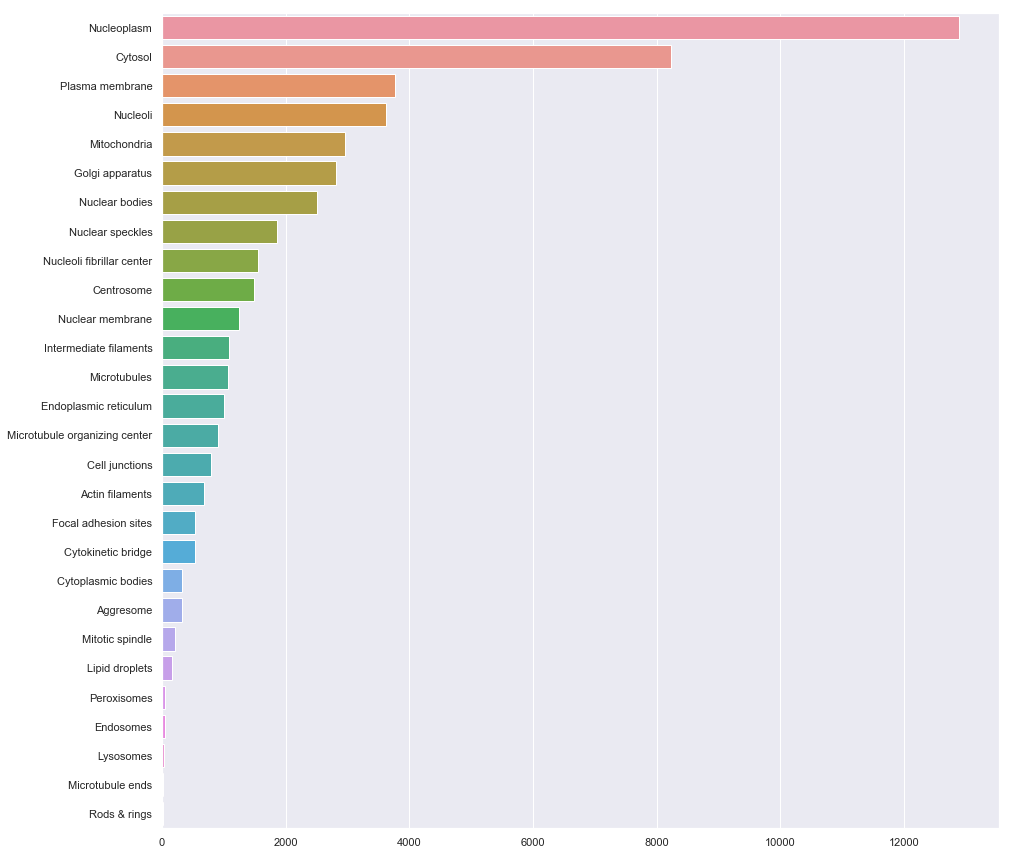

In [9]:
target_counts = train_labels.drop(["Id", "Target"],axis=1).sum(axis=0).sort_values(ascending=False)
plt.figure(figsize=(15,15))
sns.barplot(y=target_counts.index.values, x=target_counts.values, order=target_counts.index)

### Take-Away

* We can see that most common protein structures belong to coarse grained cellular components like the plasma membrane, the cytosol and the nucleus. 
* In contrast small components like the lipid droplets, peroxisomes, endosomes, lysosomes, microtubule ends, rods and rings are very seldom in our train data. For these classes the prediction will be very difficult as we have only a few examples that may not cover all variabilities and as our model probably will be confused during ins learning process by the major classes. Due to this confusion we will make less accurate predictions on the minor classes.
* Consequently accuracy is not the right score here to measure your performance and validation strategy should be very fine. 

Text(0, 0.5, '% of data')

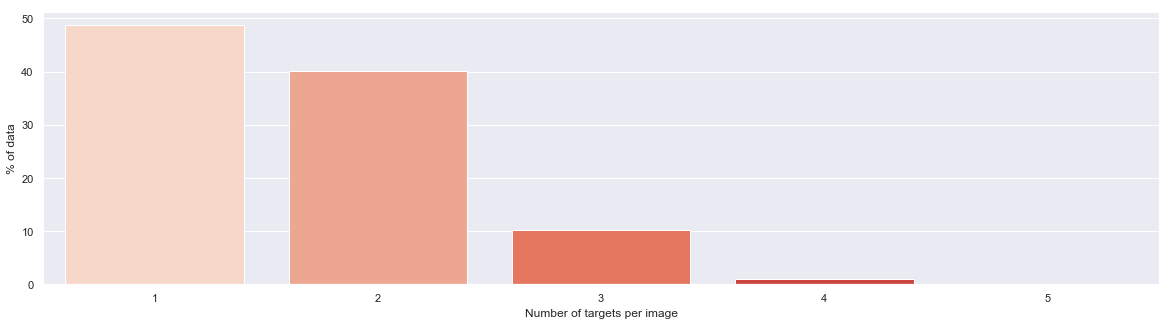

In [10]:
train_labels["number_of_targets"] = train_labels.drop(["Id", "Target"],axis=1).sum(axis=1)
count_perc = np.round(100 * train_labels["number_of_targets"].value_counts() / train_labels.shape[0], 2)
plt.figure(figsize=(20,5))
sns.barplot(x=count_perc.index.values, y=count_perc.values, palette="Reds")
plt.xlabel("Number of targets per image")
plt.ylabel("% of data")

### Take-away

* Most train images only have 1 or two target labels.
* More than 3 targets are very seldom!

## Which targets are correlated?

Let's see if we find some correlations between our targets. This way we may already see that some proteins often come together.

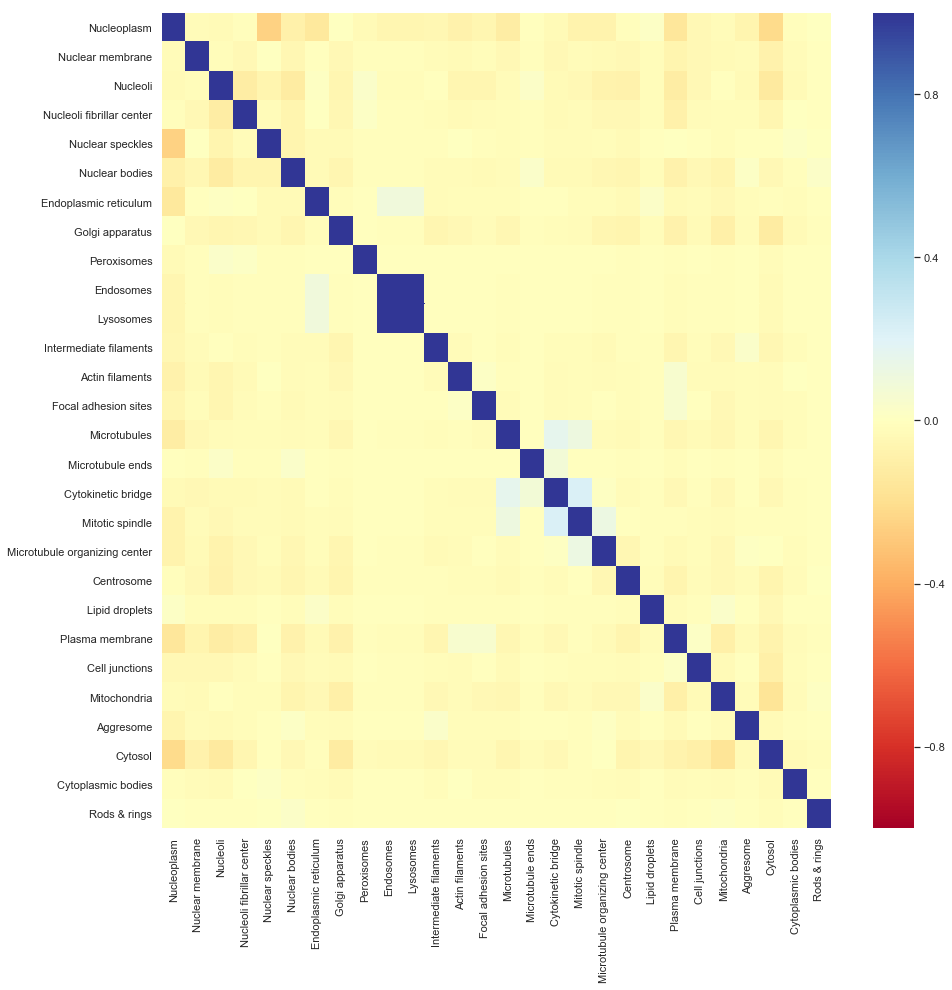

In [11]:
plt.figure(figsize=(15,15))
sns.heatmap(train_labels[train_labels.number_of_targets>1].drop(
    ["Id", "Target", "number_of_targets"],axis=1
).corr(), cmap="RdYlBu", vmin=-1, vmax=1)

### Take-away

* We can see that many targets only have very slight correlations. 
* In contrast, endosomes and lysosomes often occur together and sometimes seem to be located at the endoplasmatic reticulum. 
* In addition we find that the mitotic spindle often comes together with the cytokinetic bridge. This makes sense as both are participants for cellular division. And in this process microtubules and thier ends are active and participate as well. Consequently we find a positive correlation between these targets.

## How are special and seldom targets grouped?

### Lysosomes and endosomes

Let's start with these high correlated features!

In [12]:
def find_counts(special_target, labels):
    counts = labels[labels[special_target] == 1].drop(
        ["Id", "Target", "number_of_targets"],axis=1
    ).sum(axis=0)
    counts = counts[counts > 0]
    counts = counts.sort_values()
    return counts

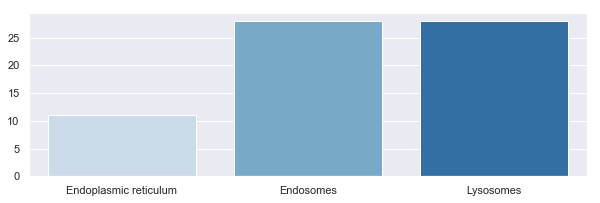

In [13]:
lyso_endo_counts = find_counts("Lysosomes", train_labels)

plt.figure(figsize=(10,3))
sns.barplot(x=lyso_endo_counts.index.values, y=lyso_endo_counts.values, palette="Blues")

### Rods and rings

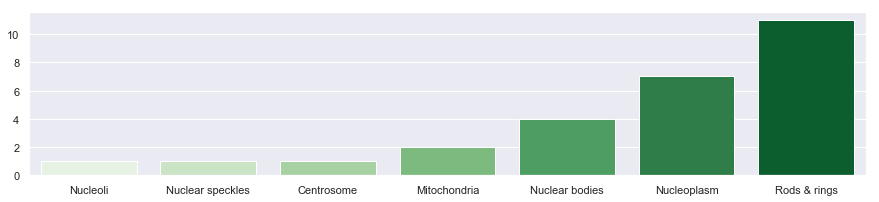

In [14]:
rod_rings_counts = find_counts("Rods & rings", train_labels)
plt.figure(figsize=(15,3))
sns.barplot(x=rod_rings_counts.index.values, y=rod_rings_counts.values, palette="Greens")

### Peroxisomes

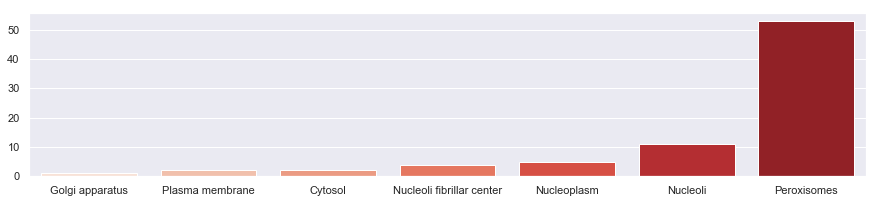

In [15]:
peroxi_counts = find_counts("Peroxisomes", train_labels)

plt.figure(figsize=(15,3))
sns.barplot(x=peroxi_counts.index.values, y=peroxi_counts.values, palette="Reds")

### Microtubule ends

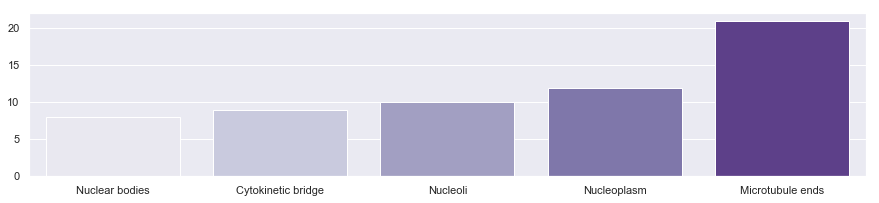

In [16]:
tubeends_counts = find_counts("Microtubule ends", train_labels)

plt.figure(figsize=(15,3))
sns.barplot(x=tubeends_counts.index.values, y=tubeends_counts.values, palette="Purples")

### Nuclear speckles

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]), <a list of 23 Text xticklabel objects>)

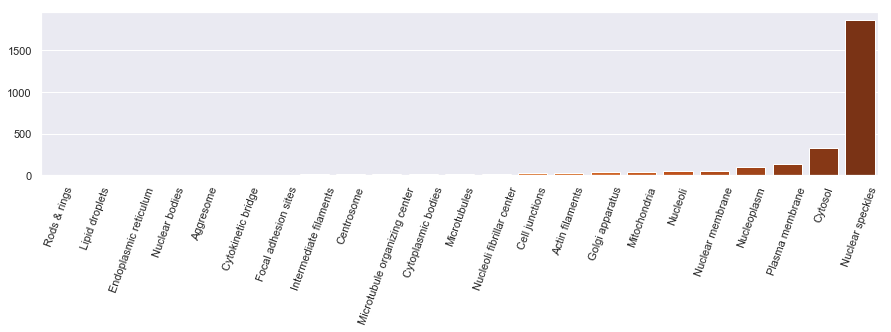

In [17]:
nuclear_speckles_counts = find_counts("Nuclear speckles", train_labels)

plt.figure(figsize=(15,3))
sns.barplot(x=nuclear_speckles_counts.index.values, y=nuclear_speckles_counts.values, palette="Oranges")
plt.xticks(rotation="70")

### Take-away

* We can see that even with very seldom targets we find some kind of grouping with other targets that reveal where the protein structure seems to be located. 
* For example, we can see that rods and rings have something to do with the nucleus whereas peroxisomes may be located in the nucleus as well as in the cytosol.
* Perhaps this patterns might help to build a more robust model!  

## How do the images look like?

### Peek into the directory

Before we start loading images, let's have a look into the train directory to get an impression of what we can find there:

In [18]:
from os import listdir

files = listdir("E:/wujeccoai_data/human_atlas_data/all/train")
for n in range(10):
    print(files[n])

00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_blue.png
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_green.png
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_red.png
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_blue.png
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_green.png
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_red.png
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0_blue.png
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0_green.png


Ah, ok, great! It seems that for one image id, there are different color channels present. Looking into the data description of this competition we can find that:

* Each image is actually splitted into 4 different image files. 
* These 4 files correspond to 4 different filter:
    * a **green** filter for the **target protein structure** of interest
    * **blue** landmark filter for the **nucleus**
    * **red** landmark filter for **microtubules**
    * **yellow** landmark filter for the **endoplasmatic reticulum**
* Each image is of size 512 x 512

Let's check if the number of files divided by 4 yields the number of target samples:

In [19]:
len(files) / 4 == train_labels.shape[0]

False

## How do images of specific targets look like?

While looking at examples, we can build an batch loader:

In [20]:
train_path = "E:/wujeccoai_data/human_atlas_data/all/train/"

In [21]:
def load_image(basepath, image_id):
    images = np.zeros(shape=(4,512,512))
    images[0,:,:] = imread(basepath + image_id + "_green" + ".png")
    images[1,:,:] = imread(basepath + image_id + "_red" + ".png")
    images[2,:,:] = imread(basepath + image_id + "_blue" + ".png")
    images[3,:,:] = imread(basepath + image_id + "_yellow" + ".png")
    return images

def make_image_row(image, subax, title):
    subax[0].imshow(image[0], cmap="Greens")
    subax[1].imshow(image[1], cmap="Reds")
    subax[1].set_title("stained microtubules")
    subax[2].imshow(image[2], cmap="Blues")
    subax[2].set_title("stained nucleus")
    subax[3].imshow(image[3], cmap="Oranges")
    subax[3].set_title("stained endoplasmatic reticulum")
    subax[0].set_title(title)
    return subax

def make_title(file_id):
    file_targets = train_labels.loc[train_labels.Id==file_id, "Target"].values[0]
    title = " - "
    for n in file_targets:
        title += label_names[n] + " - "
    return title

In [22]:
class TargetGroupIterator:
    
    def __init__(self, target_names, batch_size, basepath):
        self.target_names = target_names
        self.target_list = [reverse_train_labels[key] for key in target_names]
        self.batch_shape = (batch_size, 4, 512, 512)
        self.basepath = basepath
    
    def find_matching_data_entries(self):
        train_labels["check_col"] = train_labels.Target.apply(
            lambda l: self.check_subset(l)
        )
        self.images_identifier = train_labels[train_labels.check_col==1].Id.values
        train_labels.drop("check_col", axis=1, inplace=True)
    
    def check_subset(self, targets):
        return np.where(set(self.target_list).issuperset(set(targets)), 1, 0)
    
    def get_loader(self):
        filenames = []
        idx = 0
        images = np.zeros(self.batch_shape)
        for image_id in self.images_identifier:
            images[idx,:,:,:] = load_image(self.basepath, image_id)
            filenames.append(image_id)
            idx += 1
            if idx == self.batch_shape[0]:
                yield filenames, images
                filenames = []
                images = np.zeros(self.batch_shape)
                idx = 0
        if idx > 0:
            yield filenames, images
            

Let's try to visualize specific target groups. **In this example we will see images that contain the protein structures lysosomes or endosomes**. Set target values of your choice and the target group iterator will collect all images that are subset of your choice:

In [23]:
your_choice = ["Lysosomes", "Endosomes"]
your_batch_size = 3

In [24]:
imageloader = TargetGroupIterator(your_choice, your_batch_size, train_path)
imageloader.find_matching_data_entries()
iterator = imageloader.get_loader()

To keep the kernel dense, the target group iterator has a batch size which stands for the number of examples you like to look at once. In this example you can see a maximum amount of 3 images at one iteration.  **To observe the next 3 examples of your target group, just run the cell below again.** This way you can run the cell until you have seen all images of your group without polluting the kernel:

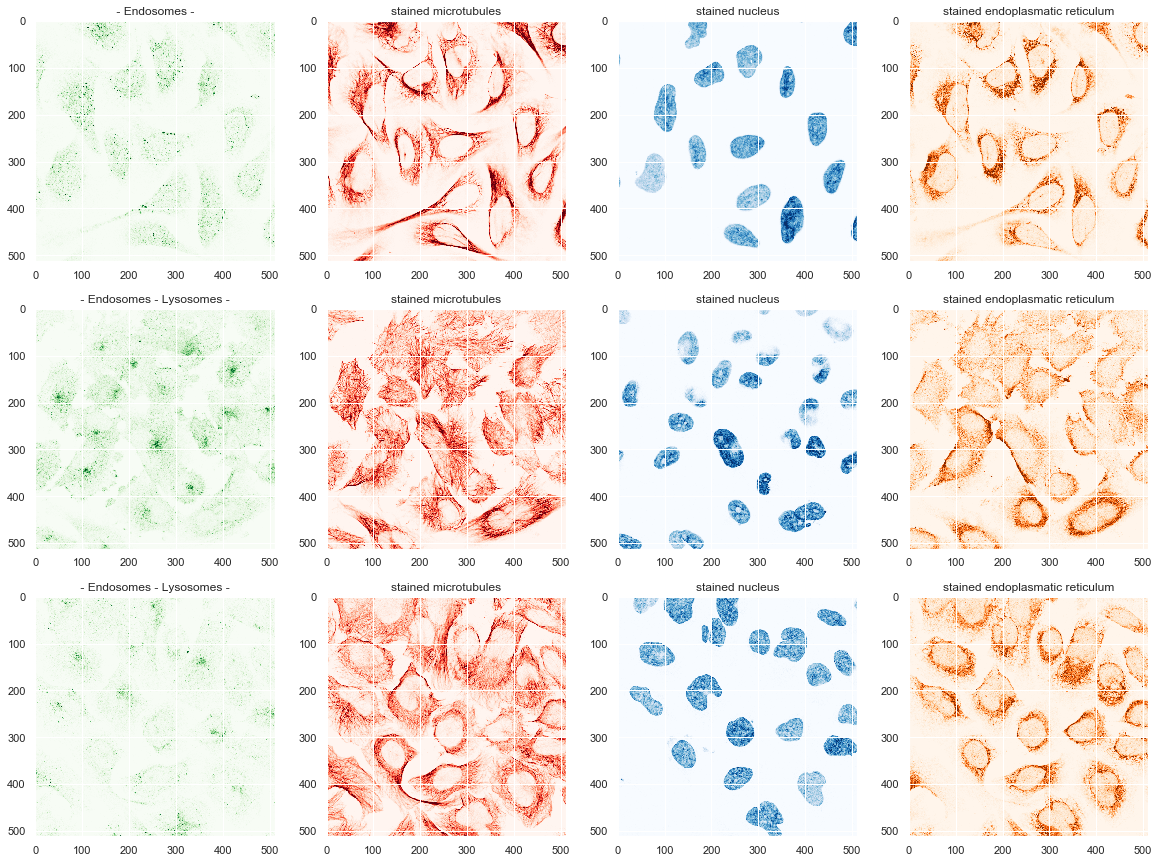

In [25]:
file_ids, images = next(iterator)

fig, ax = plt.subplots(len(file_ids),4,figsize=(20,5*len(file_ids)))
if ax.shape == (4,):
    ax = ax.reshape(1,-1)
for n in range(len(file_ids)):
    make_image_row(images[n], ax[n], make_title(file_ids[n]))

### Take-Away

* Looking at this few examples we can already obtain some insights:
    * The staining of target proteins in the green channel was not equally successful. The **images differ in their intensities and the target proteins are not always located the same way**. The first image you can get by the loader shows endosomes that are spread all over the cells and in the second and third you can find endosomes and lysosomes more concetrated around the nucleus. 
    * Especially **in the red channel we can see morphological differences**. It looks like if the cells are of different types. This is just an assumption but perhaps one could use the red channel information to reveal cell types. 

## Building a baseline model

### K-Fold Cross-Validation

Let's see how many test and train samples we have in this competition:

In [26]:
train_files = listdir("E:/wujeccoai_data/human_atlas_data/all/train")
test_files = listdir("E:/wujeccoai_data/human_atlas_data/all/test")
percentage = np.round(len(test_files) / len(train_files) * 100)

print("The test set size turns out to be {} % compared to the train set.".format(percentage))

The test set size turns out to be 38.0 % compared to the train set.


To understand the performance of our model we will use k-fold cross validation. The train data is splitted into k chunks and each chunk is used once for testing the prediction performance whereas the others are used for training. As our targets show relationships seemed to be grouped somehow the performance per test chunk probably highly depends on the target distribution per test chunk. For example there could be chunks with very seldom targets that may obtain a bad score and some chunks with very common targets and a very good score. To reduce this effect, we will repeat the K-Fold several times and look at scoing distributions in the end.

As our test data is 38 % of size compared to the train set it makes sense to use 3-Fold cross validation where the test set is 33 % of size compared to the train set. As we are working with neural networks that can be demanding in computational resources, let's only use 2 repetitions.

In [27]:
from sklearn.model_selection import RepeatedKFold

splitter = RepeatedKFold(n_splits=3, n_repeats=1, random_state=0)

This splitter is now a generator. Hence if you call splitters split method it will yield one Fold of the repeated K-Folds. Consequently if we choose n_repeats=2 we will end up with 6 Folds in total: 3 Folds for the first cross validation and again 3 Folds for the repeated cross validation. We will perform the splitting on the image ids. This way we can easily load images and targets given the chunk ids. Due to performance reasons I will only use one cv-fold to explore results and one repeat!

In [28]:
partitions = []

for train_idx, test_idx in splitter.split(train_labels.index.values):
    partition = {}
    partition["train"] = train_labels.Id.values[train_idx]
    partition["validation"] = train_labels.Id.values[test_idx]
    partitions.append(partition)
    print("TRAIN:", train_idx, "TEST:", test_idx)
    print("TRAIN:", len(train_idx), "TEST:", len(test_idx))

TRAIN: [    1     2     3 ... 31063 31064 31065] TEST: [    0     4     6 ... 31069 31070 31071]
TRAIN: 20714 TEST: 10358
TRAIN: [    0     4     6 ... 31069 31070 31071] TEST: [    1     2     3 ... 31060 31061 31065]
TRAIN: 20715 TEST: 10357
TRAIN: [    0     1     2 ... 31069 31070 31071] TEST: [   10    11    13 ... 31062 31063 31064]
TRAIN: 20715 TEST: 10357


In [29]:
partitions[0]["train"][0:5]

array(['000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0',
       '000a9596-bbc4-11e8-b2bc-ac1f6b6435d0',
       '000c99ba-bba4-11e8-b2b9-ac1f6b6435d0',
       '001bcdd2-bbb2-11e8-b2ba-ac1f6b6435d0',
       '002daad6-bbc9-11e8-b2bc-ac1f6b6435d0'], dtype=object)

Collecting ideas

Next we need to setup a simple baseline model. This need not be very complex or very good. Its our first attempt to play with and to figure out how to improve. For this purpose let's use the deep learning library keras. This tools makes it easy for us to build and train neural networks. First of all, we should collect some ideas:

To stay simple let's use only the green channel image of our images per id. The competition says that it shows the stained target proteins and consequently it's hopefully the most informative one. The other images are like references showing microtubules, nucleus and endoplasmatic reticulum. We don't acutally now how informative they are and in our current state they would blow up our neural network with a huge amount of network weigths that we might not need.
Let's use generators to only load data images of our batch and not all in once. Using keras fit_generator, evaluate_generator and predict_generator we can directly connect them to keras without worrying much about how keras does its job. For this purpose I highly follow a descprition of a post in the www for which you will find the link below.
It could be advantegous to write a small class that does simple preprocessing per image. This way we can easily change something of this phase without producing chaos in the model itself or during data loading.
I'm going to use a small class that hold parameters that are used or shared between the data loader, the image preprocessor and the baseline model. Passing an instance of this class to them reduced the risk of setting different parameters and obtaining mismatch errors for example during build & compile of the network layers.

Shared Parameter class

In [30]:
class ModelParameter:
    
    def __init__(self, num_classes=28,
                 image_rows=512,
                 image_cols=512,
                 batch_size=128,
                 n_channels=1,
                 row_scale_factor=4,
                 col_scale_factor=4,
                 shuffle=True,
                 n_epochs=1):
        self.num_classes = num_classes
        self.image_rows = image_rows
        self.image_cols = image_cols
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.shuffle = True
        self.row_scale_factor = row_scale_factor
        self.col_scale_factor = col_scale_factor
        self.scaled_row_dim = np.int(self.image_rows / self.row_scale_factor)
        self.scaled_col_dim = np.int(self.image_cols / self.col_scale_factor)
        self.n_epochs = n_epochs

Ok, now we will create an instance of this class and pass it to the DataGenerator, the BaseLineModel and the ImagePreprocessor.

In [31]:
parameter = ModelParameter()

Image Preprocessor

Let's write a simple image preprocessor that handles for example the rescaling of the images. Perhaps we can expand its functionality during improvement of the baseline model.

In [32]:
from skimage.transform import resize

class ImagePreprocessor:
    
    def __init__(self, modelparameter):
        self.parameter = modelparameter
        self.scaled_row_dim = self.parameter.scaled_row_dim
        self.scaled_col_dim = self.parameter.scaled_col_dim
        self.n_channels = self.parameter.n_channels
    
    def preprocess(self, image):
        image = self.resize(image)
        image = self.reshape(image)
        image = self.normalize(image)
        return image
    
    def resize(self, image):
        image = resize(image, (self.scaled_row_dim, self.scaled_col_dim))
        return image
    
    def reshape(self, image):
        image = np.reshape(image, (image.shape[0], image.shape[1], self.n_channels))
        return image
    
    def normalize(self, image):
        image /= 255 
        return image
        

Let's create an instance of this preprocessor and pass it to the data generator.

In [33]:
preprocessor = ImagePreprocessor(parameter)

Looking at a preprocessed example image

(512, 512)
(128, 128, 1)


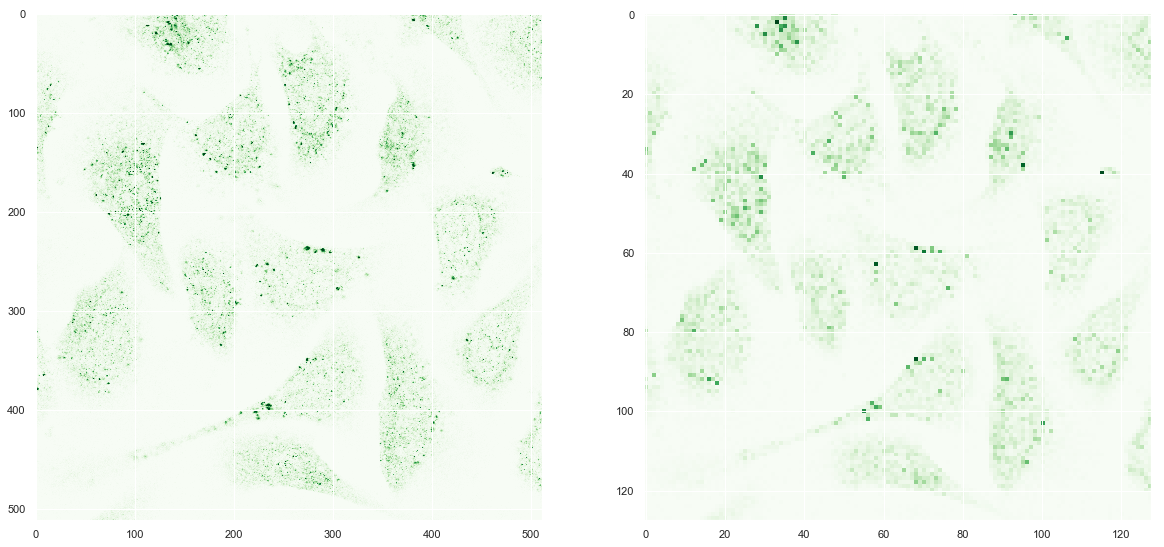

In [34]:
example = images[0,0]
preprocessed = preprocessor.preprocess(example)
print(example.shape)
print(preprocessed.shape)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(example, cmap="Greens")
ax[1].imshow(preprocessed.reshape(parameter.scaled_row_dim,parameter.scaled_col_dim), cmap="Greens")

You can see that we have lost a lot of information by downscaling the image!

Data Generator
I highly build upon the nice data generator presented by Shervine Amidi. Thank you! :-)

WORK in progess! - Currently there are missing samples of the last batch < batch_size

In [35]:
import keras

class DataGenerator(keras.utils.Sequence):
    
    def __init__(self, basepath, list_IDs, labels, modelparameter, imagepreprocessor):
        self.basepath = basepath
        self.params = modelparameter
        self.labels = labels
        self.list_IDs = list_IDs
        self.dim = (self.params.scaled_row_dim, self.params.scaled_col_dim)
        self.batch_size = self.params.batch_size
        self.n_channels = self.params.n_channels
        self.num_classes = self.params.num_classes
        self.shuffle = self.params.shuffle
        self.preprocessor = imagepreprocessor
        self.on_epoch_end()
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def get_targets_per_image(self, identifier):
        return self.labels.loc[self.labels.Id==identifier].drop(
                ["Id", "Target", "number_of_targets"], axis=1).values
            
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.num_classes), dtype=int)
        # Generate data
        for i, identifier in enumerate(list_IDs_temp):
            # Store sample
            image = load_image(self.basepath, identifier)[0]
            image = self.preprocessor.preprocess(image)
            # Store class
            y[i] = self.get_targets_per_image(identifier)
        return X, y
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

CNN Baseline model using keras

In [36]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.losses import binary_crossentropy
from keras.optimizers import Adadelta


class BaseLineModel:
    
    def __init__(self, modelparameter):
        self.params = modelparameter
        self.num_classes = self.params.num_classes
        self.img_rows = self.params.scaled_row_dim
        self.img_cols = self.params.scaled_col_dim
        self.n_channels = self.params.n_channels
        self.input_shape = (self.img_rows, self.img_cols, self.n_channels)
        self.my_metrics = ['accuracy']
    
    def build_model(self):
        self.model = Sequential()
        self.model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=self.input_shape))
        self.model.add(Conv2D(32, (3, 3), activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Dropout(0.25))
        self.model.add(Flatten())
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(self.num_classes, activation='sigmoid'))
    
    def compile_model(self):
        self.model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=self.my_metrics)
    
    def set_generators(self, train_generator, validation_generator):
        self.training_generator = train_generator
        self.validation_generator = validation_generator
    
    def learn(self):
        return self.model.fit_generator(generator=self.training_generator,
                    validation_data=self.validation_generator,
                    epochs=self.params.n_epochs, 
                    use_multiprocessing=False,
                    workers=8)
    
    def score(self):
        return self.model.evaluate_generator(generator=self.validation_generator,
                                      use_multiprocessing=False, 
                                      workers=8)
    
    def predict(self):
        return self.model.predict_generator(generator=self.validation_generator,
                                           use_multiprocessing=False)

Training the baseline on the first cv-fold

In [ ]:
# Datasets
partition = partitions[0]
labels = train_labels

# Generators
training_generator = DataGenerator(train_path, partition['train'], labels, parameter, preprocessor)
validation_generator = DataGenerator(train_path, partition['validation'], labels, parameter, preprocessor)


model = BaseLineModel(parameter)
model.build_model()
model.compile_model()
model.set_generators(training_generator, validation_generator)
history = model.learn()

Epoch 1/1


Even though this accuracy looks nice it's an illusion! We are far away from a good model. Let's try to understand why...

What do the results tell us?

Let's have a look at predicted probabilites per target class:

In [ ]:
proba_predictions = model.predict()
validation_labels = train_labels.loc[train_labels.Id.isin(partition["validation"])]


In [ ]:
print(validation_labels.shape)
print(proba_predictions.shape)

In [ ]:
proba_predictions = proba_predictions[0:-10]

In [ ]:
hot_values = validation_labels.drop(["Id", "Target", "number_of_targets"], axis=1).values.flatten()
one_hot = (hot_values.sum()) / hot_values.shape[0] * 100
zero_hot = (hot_values.shape[0] - hot_values.sum()) / hot_values.shape[0] * 100

fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.distplot(proba_predictions.flatten() * 100, color="DodgerBlue", ax=ax[0])
ax[0].set_xlabel("Probability in %")
ax[0].set_ylabel("Density")
ax[0].set_title("Predicted probabilities")
sns.barplot(x=["label = 0", "label = 1"], y=[zero_hot, one_hot], ax=ax[1])
ax[1].set_ylim([0,100])
ax[1].set_title("True target label count")
ax[1].set_ylabel("Percentage")


Take-Away
We can see that our model was always very uncertain to predict the presence of a target protein. All probabilities are close to zero and there are only a few with targets where our model predicted a protein structure with higher than 10 %.
If we take a look at the true target label count we can see that most of our targets are filled with zero. This corresponds to an absence of corresponding target proteins. This makes sense: For each image we have a high probability to contain either 1 or 2 target protein structures. Their label values are one whereas all others are zero.
Consequently our high accuracy belongs to the high correct prediction of the absence of target proteins. In contrast we weren't able to predict the presence of a target protein which is the most relevant part!
Now a bell should ring :-) Have you ever heard about imbalanced classes and model confusion?

To which targets do the high and small predicted probabilities belong to?

In [ ]:
mean_predictions = np.mean(proba_predictions, axis=0)
std_predictions = np.std(proba_predictions, axis=0)
mean_targets = validation_labels.drop(["Id", "Target", "number_of_targets"], axis=1).mean()

labels = validation_labels.drop(["Id", "Target", "number_of_targets"], axis=1).columns.values

fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.barplot(x=labels,
            y=mean_predictions,
            ax=ax[0])
ax[0].set_xticklabels(labels=labels,
                      rotation=90)
ax[0].set_ylabel("Mean predicted probability")
ax[0].set_title("Mean predicted probability per class over all samples")
sns.barplot(x=labels,
           y=std_predictions,
           ax=ax[1])
ax[1].set_xticklabels(labels=labels,
                      rotation=90)
ax[1].set_ylabel("Standard deviation")
ax[1].set_title("Standard deviation of predicted probability per class over all samples")

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
sns.barplot(x=labels, y=mean_targets.values, ax=ax)
ax.set_xticklabels(labels=labels,
                      rotation=90)
ax.set_ylabel("Percentage of hot (1)")
ax.set_title("Percentage of hot counts (ones) per target class")

Take-Away
Our baseline model seemed to learn something even if this something does not look very nice. Instead of predicting 0.5 probability of each target class if yields the fraction of the number of one-hot-targets devided by the number of of zero-hot targets. Taking a look at the standard deviation we can see that all samples have the same predicted values. There is no deviation, no difference between them. This is of course very bad!
Hence, our next goal should be to find out what to tune in such a way that our model really starts learning!

One-Step-Improvement
Ok, again let's go one step back and choose the most common target proteins that are present in our data: nucleoplasm, cytosol and plasma membrane. If we are not able to predict them we can go home and stay in bed ;-) .

The target wish list
To introduce a target wishlist that we can change whenever we want we need to improve the data generator. For this purpose we're going to extend the class we have already written. Taking a closer look at the base generator you can see that there is just one line code in def data_generation(self, list_IDs_temp) we have to change, namely the part with y[i] = ... inside the for loop over temp list ids (image identifiers of the batch). To make things easier, I added a small method to the DataGenerator we already had:

In [ ]:
def get_targets_per_image(self, identifier):
        return self.labels.loc[self.labels.Id==identifier].drop(
                ["Id", "Target", "number_of_targets"], axis=1).values

This method just avoids the direct pass to y[i], the targets per image in a batch. Now, we can overwrite this method in our ImprovedDataGenerator without loosing functionality:

In [ ]:
class ImprovedDataGenerator(DataGenerator):
    
    # in contrast to the base DataGenerator we add a target wishlist to init
    def __init__(self,basepath, list_IDs, labels, modelparameter, imagepreprocessor, target_wishlist):
        super(DataGenerator, self).__init__(basepath, list_IDs, labels, modelparameter, imagepreprocessor)
        self.target_wishlist = target_wishlist
    
    def get_targets_per_image(self, identifier):
        return self.labels.loc[self.labels.Id==identifier, self.target_wishlist].values

Plug and Play with the baseline model
:-)

This part makes fun! Actually I don't know if our model learns something. But we can try to find out by improving our model adding new features and playing with different parameter settings. The latter I like to do in a plug-and-play style: Setting the flag improve=True adds a change to our model whereas improve=False uses the old concept we already used in the baseline.

Add scoring metrics
We have already seen that the accuracy score is an illusion and does not help to figure out how good our predictions are. Let's take a closer look to the competition scoring and alternatives:

F1 macro score: Check out this nice implementation of Guglielmo Camporese. Thank you very much! We can easily add it to our model.
But even with that score we should be careful! We have 28 different classes that are very different in their frequency of being present. In addition we have to deal with highly imbalanced classes per single target. Even for the most common target nucleoplasm there are only 40 % of samples that show it and 60 % not. This imbalance becomes even more dramatic for seldom targets like rods and rings. We should attach more importance to true positives.

In [ ]:
import keras.backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [ ]:
class ImprovedModel(BaseLineModel):
    
    def __init__(self, modelparameter, my_metrics=[f1]):
        super(BaseLineModel, self).init(modelparameter)
        self.my_metrics = my_metrics

Where to go next?